
# LLM Evaluation via Skills Assessment

Using a modified [FLASK method](https://arxiv.org/pdf/2307.10928.pdf), this notebook helps to benchmark and evaluate LLMs for your application.

With a fine-grained skills assessment and scoring LLM responses on a 1-5 likert scale, researchers found strong correlation between human and LLM evaluators.

This example compares [OpenAI's GPT-4](https://openai.com/research/gpt-4) the [LocalMentor python package](https://github.com/remyxai/LocalMentor).

## Setup

You will need an OpenAI token to complete the evaluation. If you run into import issues, please restart the runtime.

You can run the optional cell to prevent the notebook from timing out in case of long runs.

In [ ]:
# @title Set OpenAI token
from getpass import getpass

token = getpass('Enter token here')
os.environ['OPENAI_API_KEY'] = token

Enter token here··········


In [ ]:
# @title (Optional) Execute for long running processes
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

In [ ]:
!pip install -q localmentor
!pip install -q guidance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.3/229.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
tensorflow-probability 0.22.0 requires t

In [ ]:
import os
from localmentor import mentor
import guidance
from guidance import models, gen, system, user, assistant

## Evaluation

We've sampled 10 prompts for evaluating each model for faster results. You can try adding more prompts for greater confidence.

In [ ]:
# @title # Choose prompts for evaluation
prompt_1 = "What are the key factors to consider when starting a new business?" # @param {type:"string"}
prompt_2 = "What are the most common mistakes startups make and how can they be avoided?" # @param {type:"string"}
prompt_3 = "What are the best strategies for raising initial capital for a startup?" # @param {type:"string"}
prompt_4 = "How can a startup effectively validate its business idea?" # @param {type:"string"}
prompt_5 = "What are the best practices for managing cash flow in a startup?" # @param {type:"string"}
prompt_6 = "How can a startup create a strong and sustainable company culture?" # @param {type:"string"}
prompt_7 = "What are the key metrics a startup should track and why?" # @param {type:"string"}
prompt_8 = "How can a startup effectively market its product or service?" # @param {type:"string"}
prompt_9 = "What are the best strategies for a startup to handle competition?" # @param {type:"string"}
prompt_10 = "How can a startup maintain its focus and avoid distractions?" # @param {type:"string"}

prompts = [
    prompt_1,
    prompt_2,
    prompt_3,
    prompt_4,
    prompt_5,
    prompt_6,
    prompt_7,
    prompt_8,
    prompt_9,
    prompt_10
    ]

In [ ]:
# @title Helper functions
def guidance_helper(system_prompt, model, prompt, output_key, max_tokens=1500):
  mdl = model
  with system():
    mdl += system_prompt
  with user():
    mdl += prompt
  with assistant():
    mdl += gen(name=output_key, max_tokens=max_tokens)
  return mdl[output_key]

In [ ]:
# @title Generate a response per model
from ast import literal_eval

system_prompt = "Provide a comprehensive and detailed response that includes innovative insights and clear, structured explanations. Focus on delivering practical, actionable advice. Ensure relevance to the startup and tech industry, emphasizing current trends and future possibilities. Be specific in your examples and explanations, and consider adding unique perspectives or novel approaches to standard practices. Aim for clarity in communication, organizing your response logically and coherently.\n"

responses = []
for prompt in prompts:
    advice = mentor(system_prompt + prompt)

    oai_advice = guidance_helper(system_prompt, models.OpenAI("gpt-4"), prompt, "advice")
    responses.append((advice, oai_advice))

In [ ]:
# @title Score each model response

system_prompt = """You are to evaluate each response on the likert scale (1-5) for dimensions including:
Robustness
Correctness
Efficiency
Factuality
Commonsense
Comprehension
Insightfulness
Completeness
Metacognition
Readability
Conciseness
Harmlessness

Make sure to structure your responses as JSON
"""
scores = []
for response in responses:
  score = guidance_helper(system_prompt, models.OpenAI("gpt-4"), "Model A:\n" + "\n\nModel B:\n".join(response), "scores", 2000)
  scores.append(score)

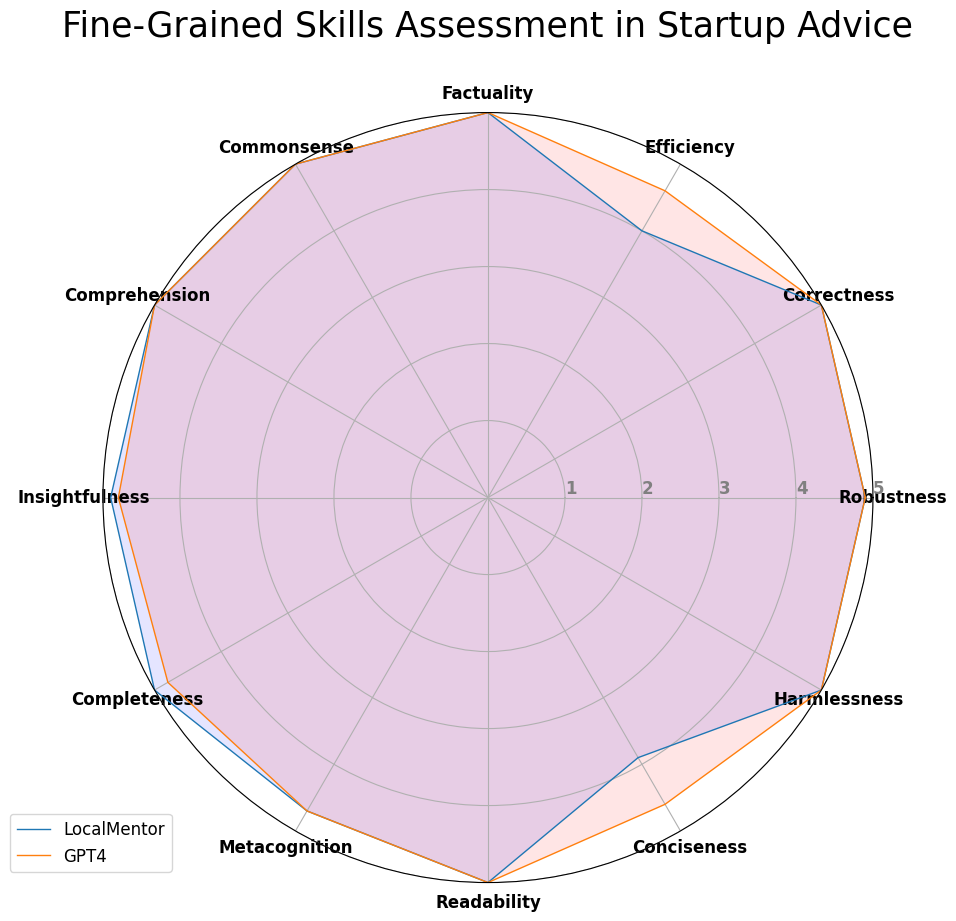

In [ ]:
# @title Plot results

import matplotlib.pyplot as plt
import pandas as pd
from math import pi
from collections import defaultdict

# Data
avg_data = [literal_eval(score) for score in scores]
average_data = defaultdict(lambda: defaultdict(list))

# Accumulate the values for each model and attribute
for entry in avg_data:
    for model, attributes in entry.items():
        if isinstance(attributes, dict):
            for attribute, value in attributes.items():
                average_data[model][attribute].append(value)


# Calculate the averages
for model, attributes in average_data.items():
    for attribute, values in attributes.items():
        average_data[model][attribute] = sum(values) / len(values)

# Convert defaultdict to regular dict for display
average_data_dict = {model: dict(attributes) for model, attributes in average_data.items()}
average_data_dict = {key: average_data_dict[key] for key in ['Model A', 'Model B']}

# Convert to DataFrame
df = pd.DataFrame(average_data_dict)

# Number of variables
categories = list(df.index)
N = len(categories)

# What will be the angle of each axis in the plot?
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, fontsize=12, fontweight='bold')

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([1,2,3,4,5], ["1","2","3","4","5"], color="grey", size=7, fontsize=12, fontweight='bold')
plt.ylim(0,5)

# Model A
values = list(df['Model A']) + list(df['Model A'])[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label='LocalMentor')
ax.fill(angles, values, 'b', alpha=0.1)

# Model B
values = list(df['Model B']) + list(df['Model B'])[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label='GPT4')
ax.fill(angles, values, 'r', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)

plt.title('Fine-Grained Skills Assessment in Startup Advice\n', fontsize=25)

# Show the plot
plt.show()
